In [1]:
import wandb
import numpy as np
import pandas as pd
from collections import defaultdict

In [387]:
api = wandb.Api()
runs = api.runs("kilian/lift")

# Teacher Prior influence

In [309]:
# Filter runs by the "beta_sweep" tag
beta_sweep_runs = [run for run in runs if "beta_sweep_2" in run.tags and run.state == "finished"]

# Output the filtered runs
print(f"Found {len(beta_sweep_runs)} runs with the tag 'beta_sweep'.")

Found 60 runs with the tag 'beta_sweep'.


In [310]:
rwd_data = defaultdict(list)
mae_data = defaultdict(list)

for run in beta_sweep_runs:
    run_id = run.id
    history = run.history(samples=10000)
    beta = run.config["encoder"]["beta_2"]
    rwd_data[beta].append(history.encoder_reward.values[-1])
    mae_data[beta].append(history.encoder_mae.values[-1])

In [311]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


betas = list(rwd_data.keys())
rwd_mean = [np.mean(val) for val in rwd_data.values()]
rwd_std = [np.std(val) for val in rwd_data.values()]
data = pd.DataFrame({
    'Scaling Factor': betas,
    'Mean Reward': rwd_mean,
    'Standard Deviation': rwd_std,
})

In [312]:
mae_mean = [np.mean(val) for val in mae_data.values()]
mae_std = [np.std(val) for val in mae_data.values()]
mae_data = pd.DataFrame({
    'Scaling Factor': betas,
    'Standard Deviation': mae_std,
    'MAE': mae_mean,
})

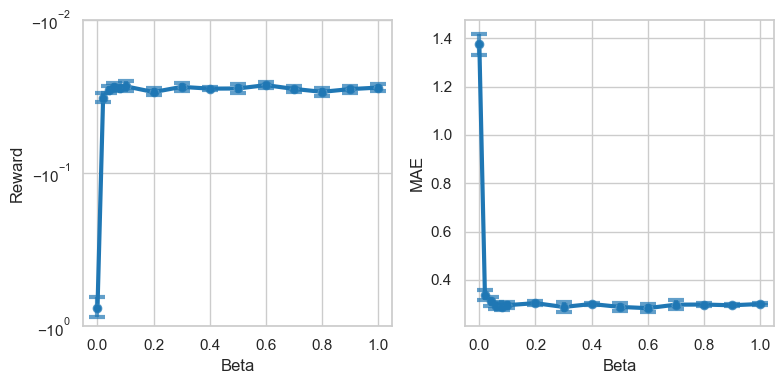

In [335]:
color = 'tab:blue'

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.set(style="whitegrid")

sns.lineplot(x='Scaling Factor', y='Mean Reward', data=data, marker='o', errorbar=None, color=color, linewidth=3, ax=axs[0])
axs[0].errorbar(data['Scaling Factor'], data['Mean Reward'], yerr=data['Standard Deviation'], fmt='o', ecolor=color, elinewidth=3, capthick=3, capsize=6, alpha=0.7, color=color)

axs[0].set_yscale('symlog', linthresh=0.01)
axs[0].set_ylim(-1., -0.01)

sns.lineplot(x='Scaling Factor', y='MAE', data=mae_data, marker='o', errorbar=None, color=color, linewidth=3, ax=axs[1])
axs[1].errorbar(mae_data['Scaling Factor'], mae_data['MAE'], yerr=mae_data['Standard Deviation'], fmt='o', ecolor=color, elinewidth=3, capthick=3, capsize=6, alpha=0.7, color=color)

axs[0].set_xlabel('Beta')
axs[1].set_xlabel('Beta')
axs[0].set_ylabel('Reward')
axs[1].set_ylabel('MAE')
plt.tight_layout()
plt.savefig('../figures/teacher_beta.png', dpi=400)
plt.show()

# MI Iter

In [382]:
# Filter runs by the "beta_sweep" tag
base_runs = [run for run in runs if "baseline" in run.tags and run.state == "finished"]

# Output the filtered runs
print(f"Found {len(base_runs)} runs with the tag 'mi_sweep'.")

Found 4 runs with the tag 'mi_sweep'.


In [383]:
baseline_data = defaultdict(list)

for run in base_runs:
    run_id = run.id
    history = run.history(samples=10000)
    run_results = {
        "seed": run.config["seed"],
        "noise": run.config["noise_range"][-1],
        "rewards": history.encoder_reward.values,
        "maes": history.encoder_mae.values,
        "mean_rewards": np.nanmean(history.encoder_reward.values[1:]),
        "last_rewards": np.nanmean(history.encoder_reward.values[-3:]),
        "mean_mae": np.nanmean(history.encoder_mae.values[1:]),
        "last_mae": np.nanmean(history.encoder_mae.values[-3:]),
    }
    for key, value in run_results.items():
        baseline_data[key].append(value)

raw_base_df = pd.DataFrame(baseline_data)
base_df = raw_base_df.groupby(['noise']).mean()

In [295]:
base_df.mean_rewards

noise
1   -0.044931
Name: mean_rewards, dtype: float64

In [296]:
# Filter runs by the "beta_sweep" tag
mi_sweep_runs = [run for run in runs if "mi_sweep_kl05" in run.tags and run.state == "finished"]

# Output the filtered runs
print(f"Found {len(mi_sweep_runs)} runs with the tag 'mi_sweep'.")

Found 200 runs with the tag 'mi_sweep'.


In [297]:
run_data = defaultdict(list)

for run in mi_sweep_runs:
    run_id = run.id
    history = run.history(samples=10000)
    run_results = {
        "seed": run.config["seed"],
        "noise": run.config["noise_range"][-1],
        "noise_slope": run.config["noise_slope_range"][-1],
        "alpha": run.config["alpha_range"][-1],
        "rewards": history.encoder_reward.values,
        "maes": history.encoder_mae.values,
        "mean_rewards": np.nanmean(history.encoder_reward.values[1:]),
        "last_rewards": np.nanmean(history.encoder_reward.values[-3:]),
        "mean_mae": np.nanmean(history.encoder_mae.values[1:]),
        "last_mae": np.nanmean(history.encoder_mae.values[-3:]),
    }
    for key, value in run_results.items():
        run_data[key].append(value)

raw_df = pd.DataFrame(run_data)

assert (raw_df.groupby(['noise', 'noise_slope', 'alpha']).size().values == 4).all(), "Not all runs have the same number of seeds"

df = raw_df.groupby(['noise', 'noise_slope', 'alpha']).mean().reset_index()

In [384]:
df_a1 = df[df['alpha'] == 1.0]
df_a3 = df[df['alpha'] == 3.0]

In [299]:
base_df.mean_rewards.values[0]

-0.044930609831557264

In [333]:
df.mean_rewards.max()

-0.029301131299224056

In [300]:
max_rwd_increase = base_df.mean_rewards.values[0] - df.mean_rewards.max()
p_increase = max_rwd_increase / base_df.mean_rewards.values[0]
print(f"max reward increse: {max_rwd_increase:.3f}, percentage increase: {p_increase:.3f}")

max reward increse: -0.016, percentage increase: 0.348


In [301]:
better_than_base_p = np.mean([a > base_df.mean_rewards.values[0] for a in df.mean_rewards.values])
better_than_base_p

0.68

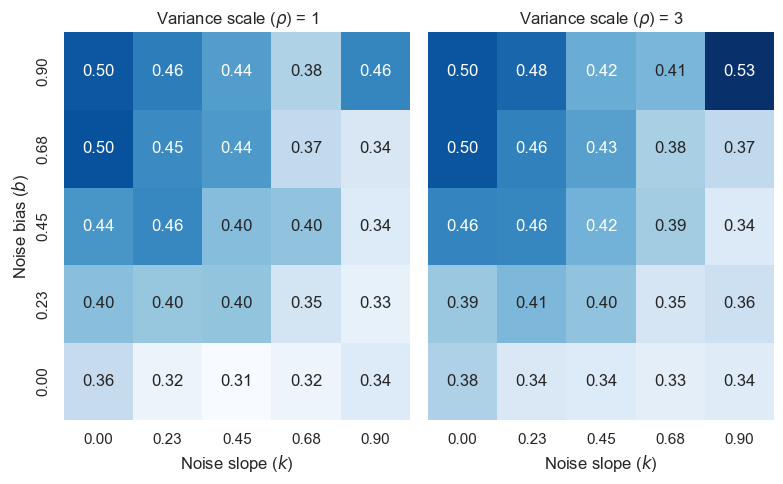

In [401]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(8, 5), sharey=True)

cmap = 'Blues'
vmin = df.mean_mae.min()
vmax = df.mean_mae.max()

df_a1_plot = df_a1.pivot(index='noise', columns='noise_slope', values='mean_mae').sort_index(ascending=False)
df_a3_plot = df_a3.pivot(index='noise', columns='noise_slope', values='mean_mae').sort_index(ascending=False)
sns.heatmap(df_a1_plot,
            annot=True, cbar=False, fmt=".2f", cmap=cmap, ax=axs[0], vmin=vmin, vmax=vmax)
sns.heatmap(df_a3_plot,
            annot=True, cbar=False, fmt=".2f", cmap=cmap, ax=axs[1], vmin=vmin, vmax=vmax)

# axs[0].set_title(r"Mean MAE ($\rho=1$)")
# axs[1].set_title(r"Mean MAE ($\rho=3$)")
axs[0].set_title(r"Variance scale ($\rho$) = 1")
axs[1].set_title(r"Variance scale ($\rho$) = 3")

# round ticks
axs[0].set_xticklabels([f"{x:.2f}" for x in df_a1_plot.index.sort_values()])
axs[0].set_yticklabels([f"{x:.2f}" for x in df_a1_plot.columns.sort_values(ascending=False)])
axs[1].set_xticklabels([f"{x:.2f}" for x in df_a3_plot.index.sort_values()])

axs[0].set_xlabel(r"Noise slope ($k$)")
axs[0].set_ylabel(r"Noise bias ($b$)")
axs[1].set_xlabel(r"Noise slope ($k$)")
axs[1].set_ylabel("")


plt.tight_layout()
plt.savefig('../figures/mi_iter_mean_mae.png', dpi=400)
plt.show()

# TODO make same as others before and add subplot titles 

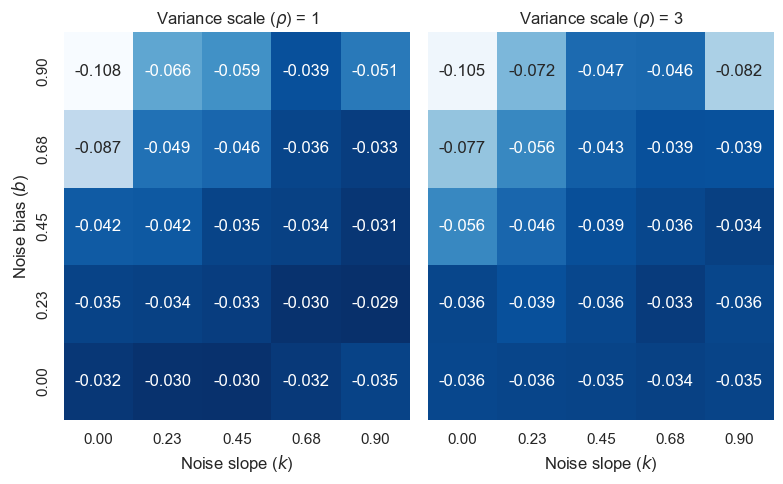

In [385]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(8, 5), sharey=True)

cmap = 'Blues'
vmin = df.mean_rewards.min()
vmax = df.mean_rewards.max()

df_a1_plot = df_a1.pivot(index='noise', columns='noise_slope', values='mean_rewards').sort_index(ascending=False)
df_a3_plot = df_a3.pivot(index='noise', columns='noise_slope', values='mean_rewards').sort_index(ascending=False)
sns.heatmap(df_a1_plot,
            annot=True, cbar=False, fmt=".3f", cmap=cmap, ax=axs[0], vmin=vmin, vmax=vmax)
sns.heatmap(df_a3_plot,
            annot=True, cbar=False, fmt=".3f", cmap=cmap, ax=axs[1], vmin=vmin, vmax=vmax)

# axs[0].set_title(r"Mean reward ($\rho=1$)")
# axs[1].set_title(r"Mean reward ($\rho=3$)")
axs[0].set_title(r"Variance scale ($\rho$) = 1")
axs[1].set_title(r"Variance scale ($\rho$) = 3")


# round ticks
axs[0].set_xticklabels([f"{x:.2f}" for x in df_a1_plot.index.sort_values()])
axs[0].set_yticklabels([f"{x:.2f}" for x in df_a1_plot.columns.sort_values(ascending=False)])
axs[1].set_xticklabels([f"{x:.2f}" for x in df_a3_plot.index.sort_values()])

axs[0].set_xlabel(r"Noise slope ($k$)")
axs[0].set_ylabel(r"Noise bias ($b$)")
axs[1].set_xlabel(r"Noise slope ($k$)")
axs[1].set_ylabel("")

plt.tight_layout()
plt.savefig('../figures/mi_iter_mean_reward.png', dpi=400)
plt.show()

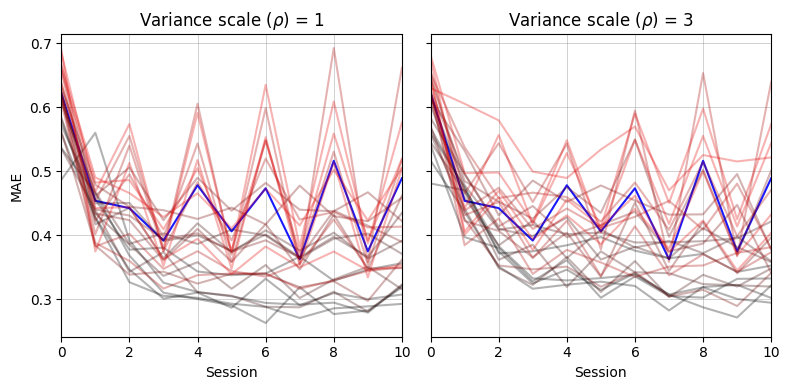

In [307]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

# plot baseline
base_color = (.1, .1, 1.)
base_mae = base_df.maes.values[0]
base_mae = base_mae[~np.isnan(base_mae)]
axs[0].plot(base_mae, color=base_color, alpha=1.0, zorder=2)
axs[1].plot(base_mae, color=base_color, alpha=1.0, zorder=2)

for i, rwd in enumerate(df_a1.maes.values):
    rwd = rwd[~np.isnan(rwd)]
    noise = df_a1.iloc[i].noise
    color = (noise, 0, 0)
    axs[0].plot(rwd, color=color, alpha=0.3, zorder=2)

for i, rwd in enumerate(df_a3.maes.values):
    rwd = rwd[~np.isnan(rwd)]
    noise = df_a3.iloc[i].noise
    color = (noise, 0, 0)
    axs[1].plot(rwd, color=color, alpha=0.3, zorder=2)

axs[0].set_xlabel("Session")
axs[0].set_ylabel("MAE")
axs[0].set_title(r"Variance scale ($\rho$) = 1")
axs[1].set_xlabel("Session")
# axs[1].set_ylabel("reward")
axs[1].set_title(r"Variance scale ($\rho$) = 3")

# add grid in background
axs[0].grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5, zorder=1)
axs[1].grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5, zorder=1)
axs[0].set_axisbelow(True)
axs[0].set_xlim(0, 10)
# axs[0].set_ylim(0, 1.)
axs[1].set_xlim(0, 10)

# Show the plot
plt.tight_layout()
plt.savefig('../figures/mi_iter_per_episode.png', dpi=400)
plt.show()

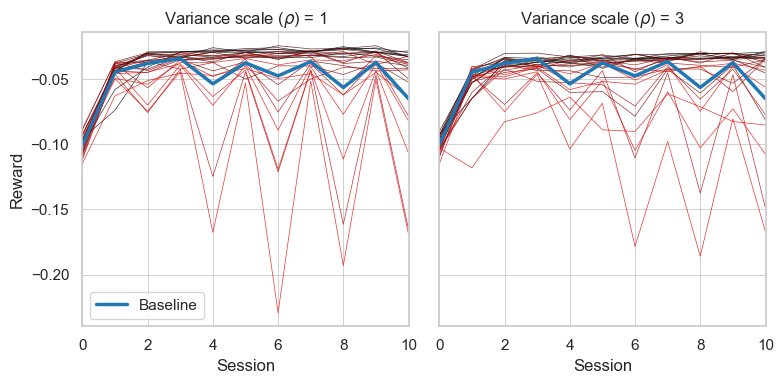

In [345]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

for i, rwd in enumerate(df_a1.rewards.values):
    rwd = rwd[~np.isnan(rwd)]
    noise = df_a1.iloc[i].noise
    color = (noise, 0, 0)
    axs[0].plot(rwd, color=color, alpha=0.8, zorder=2, linewidth=.5)

for i, rwd in enumerate(df_a3.rewards.values):
    rwd = rwd[~np.isnan(rwd)]
    noise = df_a3.iloc[i].noise
    color = (noise, 0, 0)
    axs[1].plot(rwd, color=color, alpha=0.8, zorder=2, linewidth=.5)

# plot baseline
base_color = "tab:blue"#(.2, .2, .9)
base_reward = base_df.rewards.values[0]
base_reward = base_reward[~np.isnan(base_reward)]
axs[0].plot(base_reward, color=base_color, alpha=1.0, zorder=2, linewidth=2.5, label='Baseline')
axs[1].plot(base_reward, color=base_color, alpha=1.0, zorder=2, linewidth=2.5, label='Baseline')

axs[0].set_xlabel("Session")
axs[0].set_ylabel("Reward")
axs[0].set_title(r"Variance scale ($\rho$) = 1")
axs[1].set_xlabel("Session")
# axs[1].set_ylabel("reward")
axs[1].set_title(r"Variance scale ($\rho$) = 3")

# add grid in background
axs[0].grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5, zorder=1)
axs[1].grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5, zorder=1)
axs[0].set_axisbelow(True)
axs[0].set_xlim(0, 10)
# axs[0].set_ylim(0, 1.)
axs[1].set_xlim(0, 10)

axs[0].legend()

# Show the plot
plt.tight_layout()
plt.savefig('../figures/mi_iter_rwd_per_episode.png', dpi=400)
plt.show()

# Conditioned baseline

In [388]:
# Filter runs by the "beta_sweep" tag
cond_baseline_runs = [run for run in runs if "baseline_v2" in run.tags and run.state == "finished"]

# Output the filtered runs
print(f"Found {len(cond_baseline_runs)} runs with the tag 'mi_sweep'.")

Found 50 runs with the tag 'mi_sweep'.


In [389]:
cond_baseline_data = defaultdict(list)

for run in cond_baseline_runs:
    run_id = run.id
    history = run.history(samples=10000)
    run_results = {
        "noise": run.config["noise_range"][-1],
        "noise_slope": run.config["noise_slope_range"][-1],
        "alpha": run.config["alpha_range"][-1],
        "rewards": history.encoder_reward.values,
        "maes": history.encoder_mae.values,
        "mean_rewards": np.nanmean(history.encoder_reward.values[1:]),
        "last_rewards": np.nanmean(history.encoder_reward.values[-3:]),
        "mean_mae": np.nanmean(history.encoder_mae.values[1:]),
        "last_mae": np.nanmean(history.encoder_mae.values[-3:]),
    }
    for key, value in run_results.items():
        cond_baseline_data[key].append(value)

raw_cond_baseline_df = pd.DataFrame(cond_baseline_data)

cond_baseline_df = raw_cond_baseline_df.groupby(['noise', 'noise_slope', 'alpha']).mean().reset_index()

In [390]:
cond_baseline_df_a1 = cond_baseline_df[cond_baseline_df['alpha'] == 1.0]
cond_baseline_df_a3 = cond_baseline_df[cond_baseline_df['alpha'] == 3.0]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


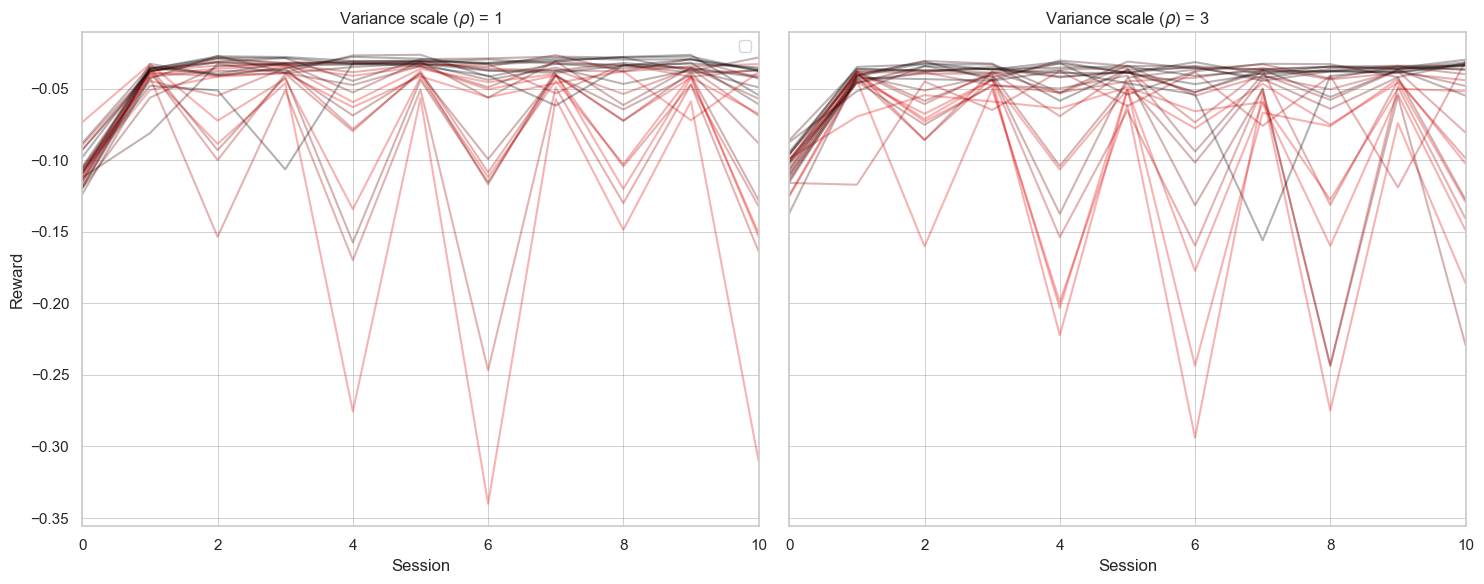

In [461]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

for i, rwd in enumerate(cond_baseline_df_a1.rewards.values):
    rwd = rwd[~np.isnan(rwd)]
    noise = cond_baseline_df_a1.iloc[i].noise
    color = (noise, 0, 0)
    axs[0].plot(rwd, color=color, alpha=0.3, zorder=2)

for i, rwd in enumerate(cond_baseline_df_a3.rewards.values):
    rwd = rwd[~np.isnan(rwd)]
    noise = cond_baseline_df_a3.iloc[i].noise
    color = (noise, 0, 0)
    axs[1].plot(rwd, color=color, alpha=0.3, zorder=2)

axs[0].set_xlabel("Session")
axs[0].set_ylabel("Reward")
axs[0].set_title(r"Variance scale ($\rho$) = 1")
axs[1].set_xlabel("Session")
# axs[1].set_ylabel("reward")
axs[1].set_title(r"Variance scale ($\rho$) = 3")

# add grid in background
axs[0].grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5, zorder=1)
axs[1].grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5, zorder=1)
axs[0].set_axisbelow(True)
axs[0].set_xlim(0, 10)
# axs[0].set_ylim(0, 1.)
axs[1].set_xlim(0, 10)

axs[0].legend()

# Show the plot
plt.tight_layout()
# plt.savefig('../figures/mi_iter_rwd_per_episode.png', dpi=400)
plt.show()

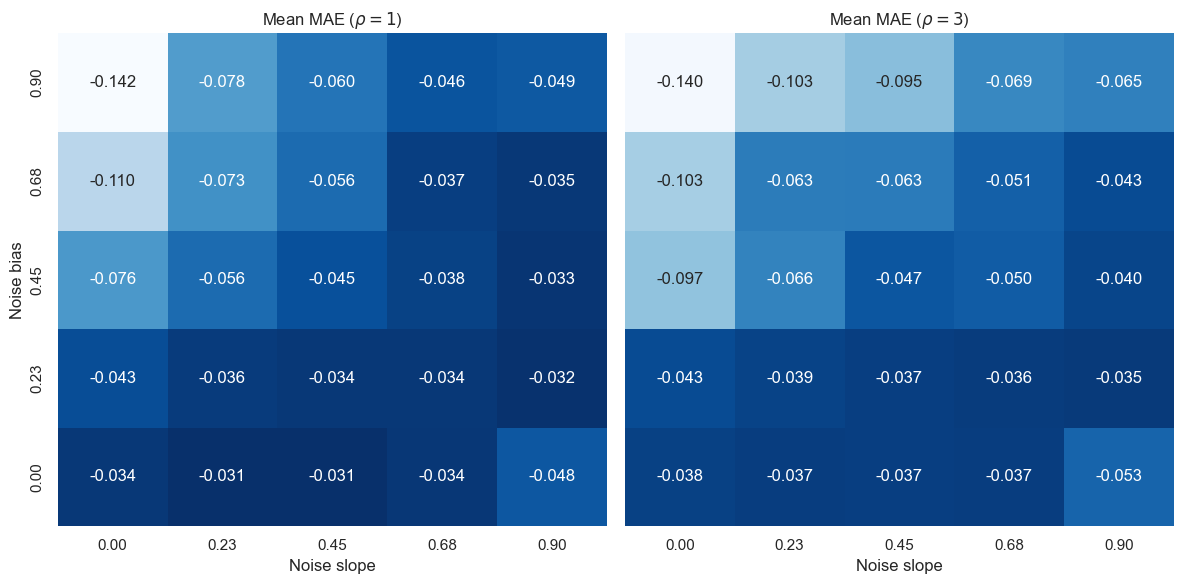

In [462]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

cmap = 'Blues'
vmin = cond_baseline_df.mean_rewards.min()
vmax = cond_baseline_df.mean_rewards.max()

cond_baseline_df_a1_plot = cond_baseline_df_a1.pivot(index='noise', columns='noise_slope', values='mean_rewards').sort_index(ascending=False)
cond_baseline_df_a3_plot = cond_baseline_df_a3.pivot(index='noise', columns='noise_slope', values='mean_rewards').sort_index(ascending=False)
sns.heatmap(cond_baseline_df_a1_plot,
            annot=True, cbar=False, fmt=".3f", cmap=cmap, ax=axs[0], vmin=vmin, vmax=vmax)
sns.heatmap(cond_baseline_df_a3_plot,
            annot=True, cbar=False, fmt=".3f", cmap=cmap, ax=axs[1], vmin=vmin, vmax=vmax)

axs[0].set_title(r"Mean MAE ($\rho=1$)")
axs[1].set_title(r"Mean MAE ($\rho=3$)")

# round ticks
axs[0].set_xticklabels([f"{x:.2f}" for x in cond_baseline_df_a1_plot.index.sort_values()])
axs[0].set_yticklabels([f"{x:.2f}" for x in cond_baseline_df_a1_plot.columns.sort_values(ascending=False)])
axs[1].set_xticklabels([f"{x:.2f}" for x in cond_baseline_df_a3_plot.index.sort_values()])

axs[0].set_xlabel("Noise slope")
axs[0].set_ylabel("Noise bias")
axs[1].set_xlabel("Noise slope")
axs[1].set_ylabel("")

plt.tight_layout()
# plt.savefig('../figures/mi_iter_mean_mae.png', dpi=400)
plt.show()

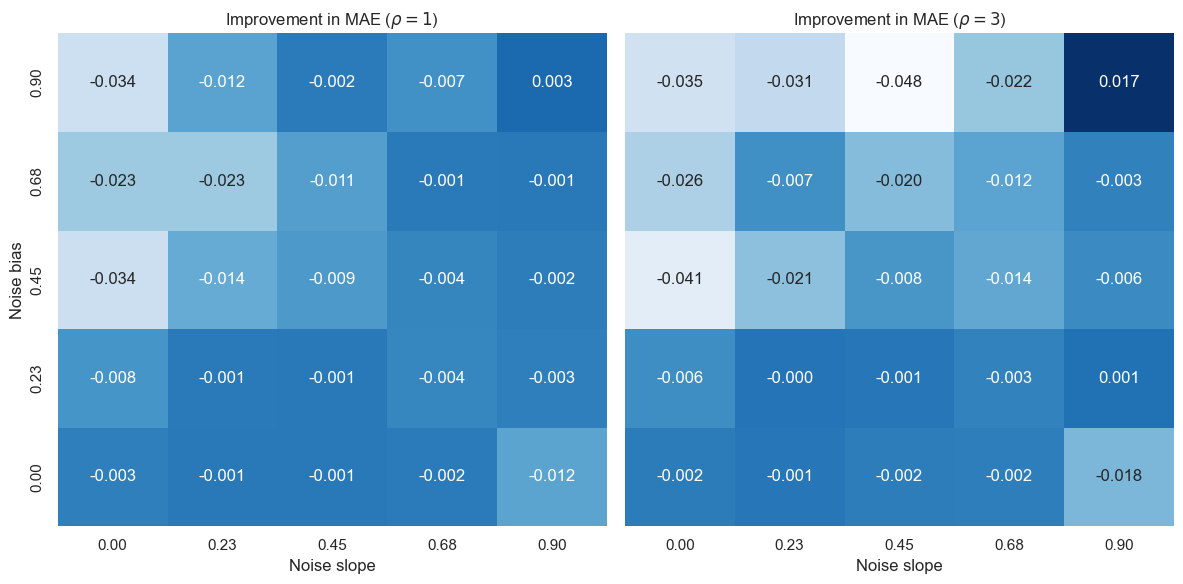

In [464]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

cmap = 'Blues'

df_a1_plot = df_a1.pivot(index='noise', columns='noise_slope', values='mean_rewards').sort_index(ascending=False)
df_a3_plot = df_a3.pivot(index='noise', columns='noise_slope', values='mean_rewards').sort_index(ascending=False)

cond_baseline_df_a1_plot = cond_baseline_df_a1.pivot(index='noise', columns='noise_slope', values='mean_rewards').sort_index(ascending=False)
cond_baseline_df_a3_plot = cond_baseline_df_a3.pivot(index='noise', columns='noise_slope', values='mean_rewards').sort_index(ascending=False)

# cond_diff_a1 = (cond_baseline_df_a1_plot / df_a1_plot) - 1 
# cond_diff_a3 = (cond_baseline_df_a3_plot / df_a3_plot) - 1 

cond_diff_a1 = cond_baseline_df_a1_plot - df_a1_plot 
cond_diff_a3 = cond_baseline_df_a3_plot - df_a3_plot 

vmin = min([cond_diff_a1.min().min(), cond_diff_a3.min().min()])
vmax = max([cond_diff_a1.max().max(), cond_diff_a3.max().max()])

sns.heatmap(cond_diff_a1,
            annot=True, cbar=False, fmt=".3f", cmap=cmap, ax=axs[0], vmin=vmin, vmax=vmax)
sns.heatmap(cond_diff_a3,
            annot=True, cbar=False, fmt=".3f", cmap=cmap, ax=axs[1], vmin=vmin, vmax=vmax)

axs[0].set_title(r"Improvement in MAE ($\rho=1$)")
axs[1].set_title(r"Improvement in MAE ($\rho=3$)")

# round ticks
axs[0].set_xticklabels([f"{x:.2f}" for x in cond_diff_a1.index.sort_values()])
axs[0].set_yticklabels([f"{x:.2f}" for x in cond_diff_a1.columns.sort_values(ascending=False)])
axs[1].set_xticklabels([f"{x:.2f}" for x in cond_diff_a3.index.sort_values()])

axs[0].set_xlabel("Noise slope")
axs[0].set_ylabel("Noise bias")
axs[1].set_xlabel("Noise slope")
axs[1].set_ylabel("")

plt.tight_layout()
# plt.savefig('../figures/mi_iter_mean_mae.png', dpi=400)
plt.show()

# With learning
From alpha = 3 (initial) to alpha = 1 (last)

In [161]:
# Filter runs by the "beta_sweep" tag
learning_runs = [run for run in runs if "mi_sweep_kl05_learning" in run.tags and run.state == "finished"]

# Output the filtered runs
print(f"Found {len(learning_runs)} runs with the tag 'mi_sweep'.")

Found 25 runs with the tag 'mi_sweep'.


In [164]:
learning_data = defaultdict(list)

for run in learning_runs:
    run_id = run.id
    history = run.history(samples=10000)
    run_results = {
        "noise": run.config["noise_range"][-1],
        "noise_slope": run.config["noise_slope_range"][-1],
        "alpha": run.config["alpha_range"][-1],
        "rewards": history.encoder_reward.values,
        "maes": history.encoder_mae.values,
        "mean_rewards": np.nanmean(history.encoder_reward.values[1:]),
        "last_rewards": np.nanmean(history.encoder_reward.values[-3:]),
        "mean_mae": np.nanmean(history.encoder_mae.values[1:]),
        "last_mae": np.nanmean(history.encoder_mae.values[-3:]),
    }
    for key, value in run_results.items():
        learning_data[key].append(value)

learning_df = pd.DataFrame(learning_data)

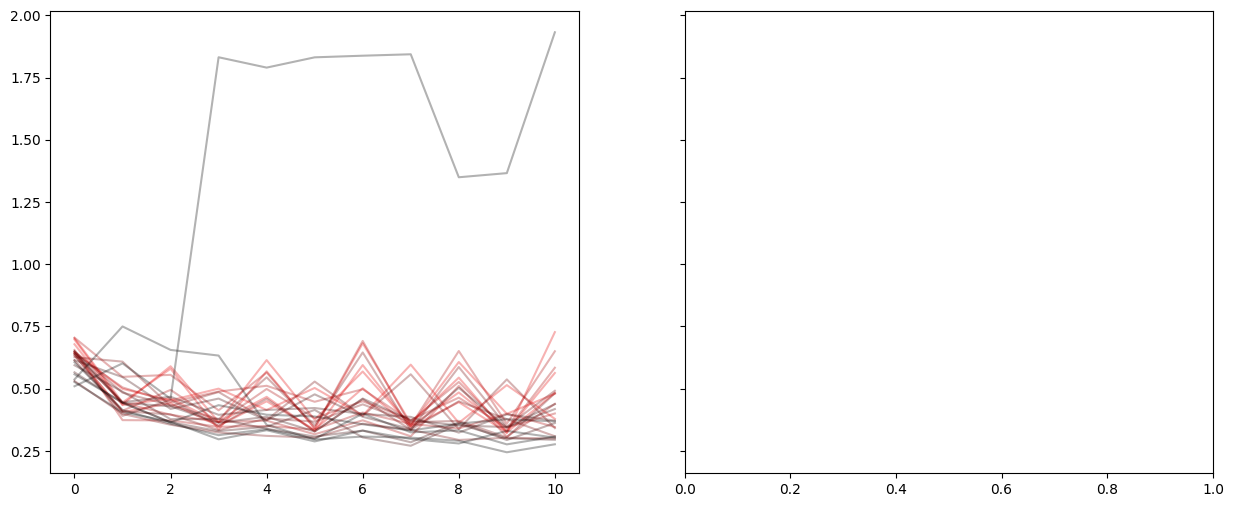

In [165]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)


for i, rwd in enumerate(learning_df.maes.values):
    rwd = rwd[~np.isnan(rwd)]
    noise = learning_df.iloc[i].noise
    color = (noise, 0, 0)
    axs[0].plot(rwd, color=color, alpha=0.3, zorder=2)

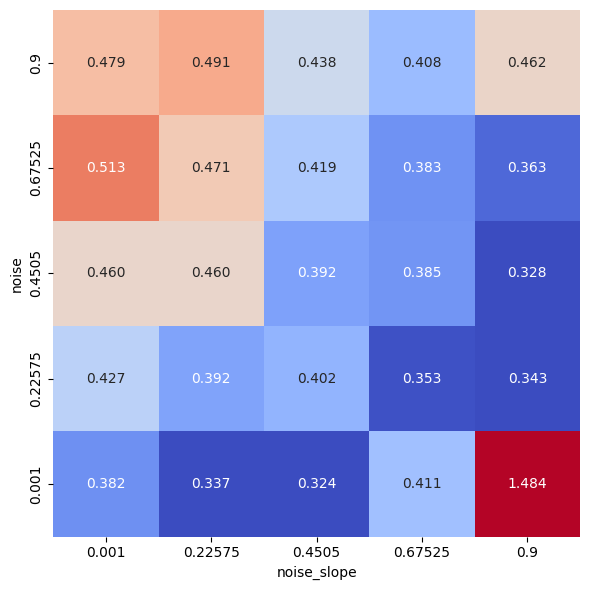

In [168]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharey=True)

cmap = 'coolwarm'
vmin = 0.35
vmax = 0.55

learning_plot_df = learning_df.pivot(index='noise', columns='noise_slope', values='mean_mae').sort_index(ascending=False)
sns.heatmap(learning_plot_df,
            annot=True, cbar=False, fmt=".3f", cmap=cmap, ax=ax, vmin=vmin, vmax=vmax)

plt.tight_layout()
plt.savefig('../figures/mi_iter_mean_reward.png', dpi=400)
plt.show()

# Deterministic noise drift

In [285]:
# Filter runs by the "beta_sweep" tag
noise_drift_runs = [run for run in runs if "mi_sweep_kl05_noise_drift" in run.tags and run.state == "finished"]

# Output the filtered runs
print(f"Found {len(noise_drift_runs)} runs with the tag 'mi_sweep'.")

Found 50 runs with the tag 'mi_sweep'.


In [281]:
noise_drift_data = defaultdict(list)

for run in noise_drift_runs:
    run_id = run.id
    history = run.history(samples=10000)
    run_results = {
        "noise": run.config["noise_range"][-1],
        "noise_slope": run.config["noise_slope_range"][-1],
        "alpha": run.config["alpha_range"][-1],
        "rewards": history.encoder_reward.values,
        "maes": history.encoder_mae.values,
        "mean_rewards": np.nanmean(history.encoder_reward.values[1:]),
        "last_rewards": np.nanmean(history.encoder_reward.values[-3:]),
        "mean_mae": np.nanmean(history.encoder_mae.values[1:]),
        "last_mae": np.nanmean(history.encoder_mae.values[-3:]),
    }
    for key, value in run_results.items():
        noise_drift_data[key].append(value)

noise_drift_df = pd.DataFrame(noise_drift_data)

In [369]:
noise_drift_df_a1 = noise_drift_df[noise_drift_df['alpha'] == 1.0]
noise_drift_df_a3 = noise_drift_df[noise_drift_df['alpha'] == 3.0]

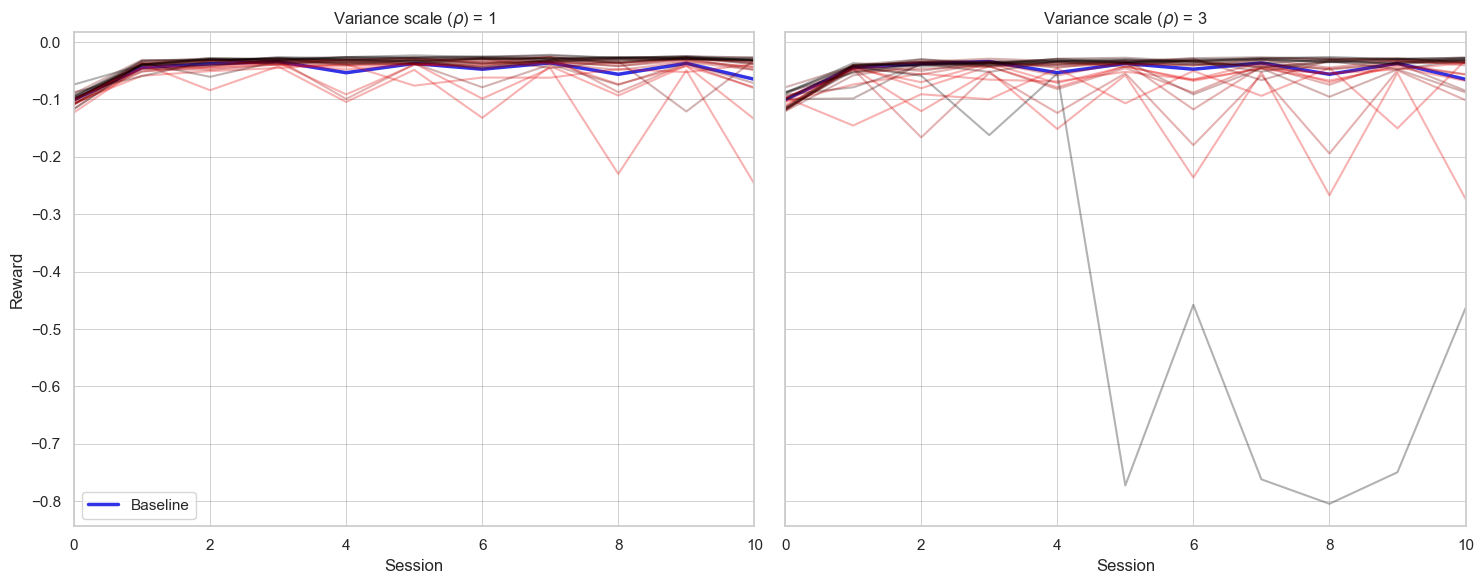

In [370]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# plot baseline
base_color = (.2, .2, .9)
base_reward = base_df.rewards.values[0]
base_reward = base_reward[~np.isnan(base_reward)]
axs[0].plot(base_reward, color=base_color, alpha=1.0, zorder=2, linewidth=2.5, label='Baseline')
axs[1].plot(base_reward, color=base_color, alpha=1.0, zorder=2, linewidth=2.5, label='Baseline')

for i, rwd in enumerate(noise_drift_df_a1.rewards.values):
    rwd = rwd[~np.isnan(rwd)]
    noise = noise_drift_df_a1.iloc[i].noise
    color = (noise, 0, 0)
    axs[0].plot(rwd, color=color, alpha=0.3, zorder=2)

for i, rwd in enumerate(noise_drift_df_a3.rewards.values):
    rwd = rwd[~np.isnan(rwd)]
    noise = noise_drift_df_a3.iloc[i].noise
    color = (noise, 0, 0)
    axs[1].plot(rwd, color=color, alpha=0.3, zorder=2)

axs[0].set_xlabel("Session")
axs[0].set_ylabel("Reward")
axs[0].set_title(r"Variance scale ($\rho$) = 1")
axs[1].set_xlabel("Session")
# axs[1].set_ylabel("reward")
axs[1].set_title(r"Variance scale ($\rho$) = 3")

# add grid in background
axs[0].grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5, zorder=1)
axs[1].grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5, zorder=1)
axs[0].set_axisbelow(True)
axs[0].set_xlim(0, 10)
# axs[0].set_ylim(0, 1.)
axs[1].set_xlim(0, 10)

axs[0].legend()

# Show the plot
plt.tight_layout()
# plt.savefig('../figures/mi_iter_rwd_per_episode.png', dpi=400)
plt.show()

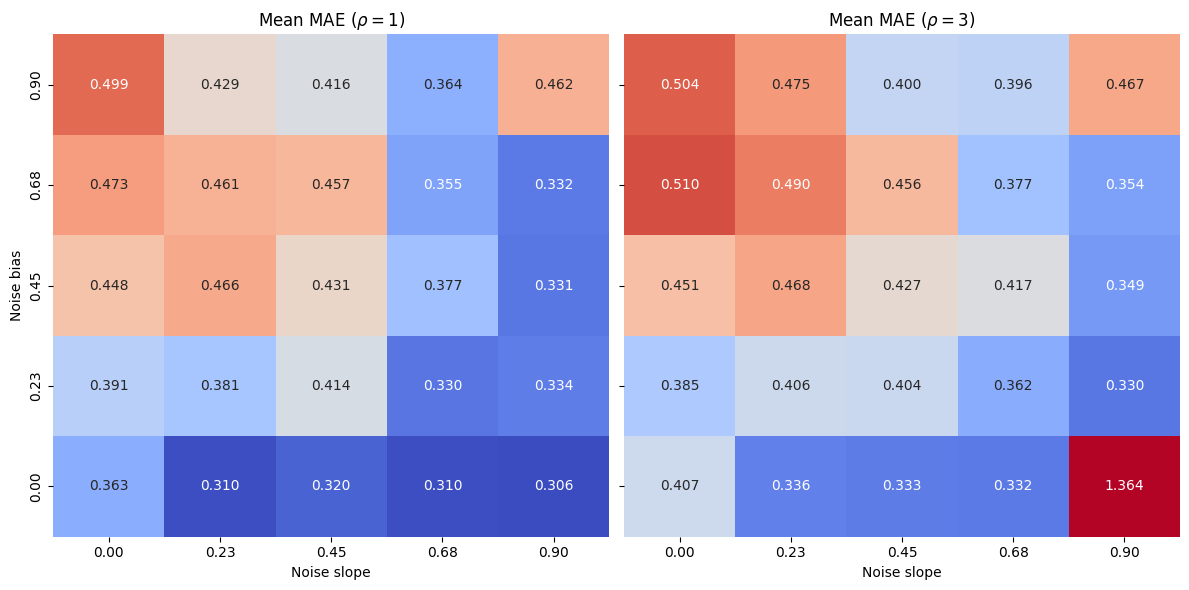

In [284]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

cmap = 'coolwarm'
vmin = df.mean_mae.min()
vmax = df.mean_mae.max()

noise_drift_df_a1_plot = noise_drift_df_a1.pivot(index='noise', columns='noise_slope', values='mean_mae').sort_index(ascending=False)
noise_drift_df_a3_plot = noise_drift_df_a3.pivot(index='noise', columns='noise_slope', values='mean_mae').sort_index(ascending=False)
sns.heatmap(noise_drift_df_a1_plot,
            annot=True, cbar=False, fmt=".3f", cmap=cmap, ax=axs[0], vmin=vmin, vmax=vmax)
sns.heatmap(noise_drift_df_a3_plot,
            annot=True, cbar=False, fmt=".3f", cmap=cmap, ax=axs[1], vmin=vmin, vmax=vmax)

axs[0].set_title(r"Mean MAE ($\rho=1$)")
axs[1].set_title(r"Mean MAE ($\rho=3$)")

# round ticks
axs[0].set_xticklabels([f"{x:.2f}" for x in noise_drift_df_a1_plot.index.sort_values()])
axs[0].set_yticklabels([f"{x:.2f}" for x in noise_drift_df_a1_plot.columns.sort_values(ascending=False)])
axs[1].set_xticklabels([f"{x:.2f}" for x in noise_drift_df_a3_plot.index.sort_values()])

axs[0].set_xlabel("Noise slope")
axs[0].set_ylabel("Noise bias")
axs[1].set_xlabel("Noise slope")
axs[1].set_ylabel("")

plt.tight_layout()
# plt.savefig('../figures/mi_iter_mean_mae.png', dpi=400)
plt.show()

# Drift

In [288]:
# Filter runs by the "beta_sweep" tag
noise_drift_runs = [run for run in runs if "mi_sweep_kl05_drift" in run.tags and run.state == "finished"]

# Output the filtered runs
print(f"Found {len(noise_drift_runs)} runs with the tag 'mi_sweep'.")

Found 50 runs with the tag 'mi_sweep'.


In [289]:
noise_drift_data = defaultdict(list)

for run in noise_drift_runs:
    run_id = run.id
    history = run.history(samples=10000)
    run_results = {
        "noise": run.config["noise_range"][-1],
        "noise_slope": run.config["noise_slope_range"][-1],
        "alpha": run.config["alpha_range"][-1],
        "rewards": history.encoder_reward.values,
        "maes": history.encoder_mae.values,
        "mean_rewards": np.nanmean(history.encoder_reward.values[1:]),
        "last_rewards": np.nanmean(history.encoder_reward.values[-3:]),
        "mean_mae": np.nanmean(history.encoder_mae.values[1:]),
        "last_mae": np.nanmean(history.encoder_mae.values[-3:]),
    }
    for key, value in run_results.items():
        noise_drift_data[key].append(value)

noise_drift_df = pd.DataFrame(noise_drift_data)

In [290]:
noise_drift_df_a1 = noise_drift_df[noise_drift_df['alpha'] == 1.0]
noise_drift_df_a3 = noise_drift_df[noise_drift_df['alpha'] == 3.0]

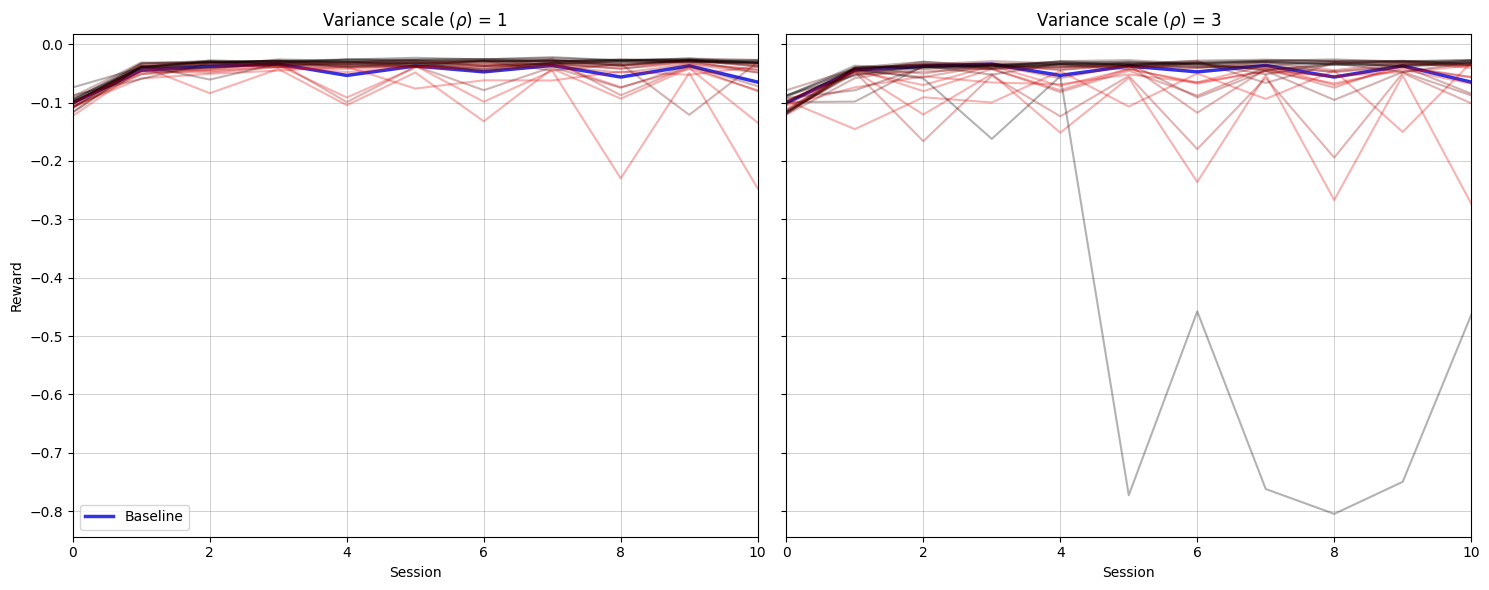

In [291]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# plot baseline
base_color = (.2, .2, .9)
base_reward = base_df.rewards.values[0]
base_reward = base_reward[~np.isnan(base_reward)]
axs[0].plot(base_reward, color=base_color, alpha=1.0, zorder=2, linewidth=2.5, label='Baseline')
axs[1].plot(base_reward, color=base_color, alpha=1.0, zorder=2, linewidth=2.5, label='Baseline')

for i, rwd in enumerate(noise_drift_df_a1.rewards.values):
    rwd = rwd[~np.isnan(rwd)]
    noise = noise_drift_df_a1.iloc[i].noise
    color = (noise, 0, 0)
    axs[0].plot(rwd, color=color, alpha=0.3, zorder=2)

for i, rwd in enumerate(noise_drift_df_a3.rewards.values):
    rwd = rwd[~np.isnan(rwd)]
    noise = noise_drift_df_a3.iloc[i].noise
    color = (noise, 0, 0)
    axs[1].plot(rwd, color=color, alpha=0.3, zorder=2)

axs[0].set_xlabel("Session")
axs[0].set_ylabel("Reward")
axs[0].set_title(r"Variance scale ($\rho$) = 1")
axs[1].set_xlabel("Session")
# axs[1].set_ylabel("reward")
axs[1].set_title(r"Variance scale ($\rho$) = 3")

# add grid in background
axs[0].grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5, zorder=1)
axs[1].grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5, zorder=1)
axs[0].set_axisbelow(True)
axs[0].set_xlim(0, 10)
# axs[0].set_ylim(0, 1.)
axs[1].set_xlim(0, 10)

axs[0].legend()

# Show the plot
plt.tight_layout()
# plt.savefig('../figures/mi_iter_rwd_per_episode.png', dpi=400)
plt.show()

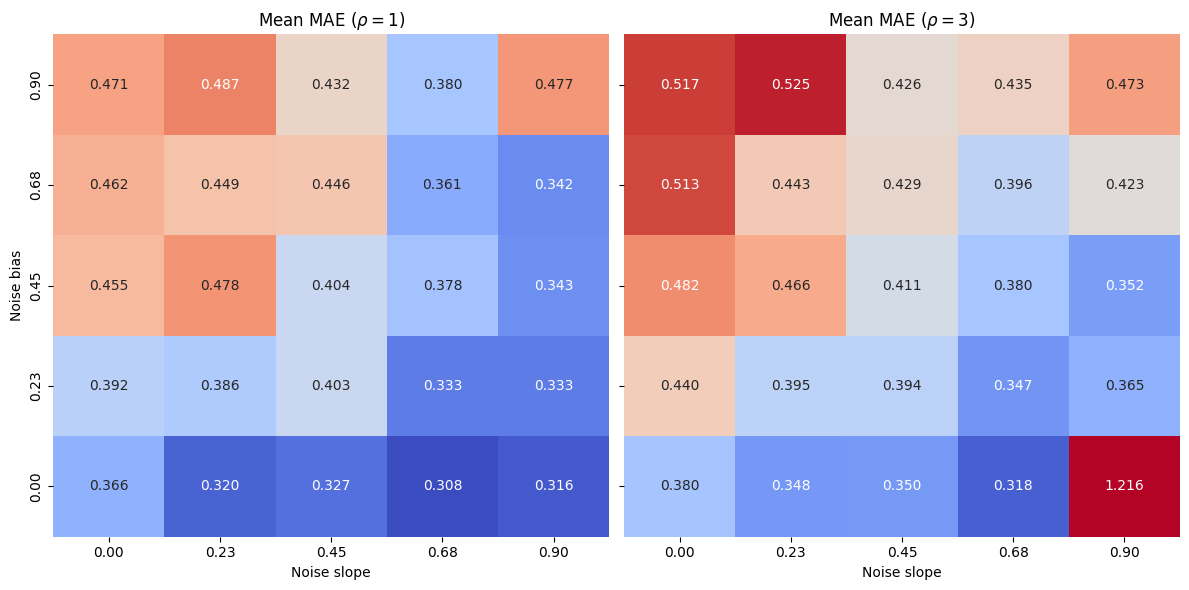

In [292]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

cmap = 'coolwarm'
vmin = df.mean_mae.min()
vmax = df.mean_mae.max()

noise_drift_df_a1_plot = noise_drift_df_a1.pivot(index='noise', columns='noise_slope', values='mean_mae').sort_index(ascending=False)
noise_drift_df_a3_plot = noise_drift_df_a3.pivot(index='noise', columns='noise_slope', values='mean_mae').sort_index(ascending=False)
sns.heatmap(noise_drift_df_a1_plot,
            annot=True, cbar=False, fmt=".3f", cmap=cmap, ax=axs[0], vmin=vmin, vmax=vmax)
sns.heatmap(noise_drift_df_a3_plot,
            annot=True, cbar=False, fmt=".3f", cmap=cmap, ax=axs[1], vmin=vmin, vmax=vmax)

axs[0].set_title(r"Mean MAE ($\rho=1$)")
axs[1].set_title(r"Mean MAE ($\rho=3$)")

# round ticks
axs[0].set_xticklabels([f"{x:.2f}" for x in noise_drift_df_a1_plot.index.sort_values()])
axs[0].set_yticklabels([f"{x:.2f}" for x in noise_drift_df_a1_plot.columns.sort_values(ascending=False)])
axs[1].set_xticklabels([f"{x:.2f}" for x in noise_drift_df_a3_plot.index.sort_values()])

axs[0].set_xlabel("Noise slope")
axs[0].set_ylabel("Noise bias")
axs[1].set_xlabel("Noise slope")
axs[1].set_ylabel("")

plt.tight_layout()
# plt.savefig('../figures/mi_iter_mean_mae.png', dpi=400)
plt.show()